<a href="https://colab.research.google.com/github/yuseifer/TFM_2024/blob/main/Entrenador_Ant_Custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym==0.17.3
!pip install pybullet==3.2.6
!pip install stable_baselines3[extra]
!pip install shimmy==1.2.1
!pip install gymnasium==0.28.1
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.0 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.17.3-py3-none-any.whl size=1654617 sha256=6e2b3babc1d868a05ee050d2bd504e548001f597bb43886bedd0dadc22e0c87e
  Stored in directory: /root/.cache/pip/wheels/af/4b/74/fcfc8238472c34d7f96508a63c962ff3ac9485a9a4137afd4e
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.1
    Uninstalling cloudpickle-2.2.1:
      Successfully uninstalled cloudpickle-2.2.1
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.21.0 requires cloudpickl

#Extracción del zip con librerías

In [ ]:
!unzip ant_custom.zip

Archive:  ant_custom.zip
   creating: ant_custom/
   creating: ant_custom/CustomAnt_Env/
   creating: ant_custom/CustomAnt_Env/envs/
  inflating: ant_custom/CustomAnt_Env/envs/AntCustomEnvEmpty.py  
  inflating: ant_custom/CustomAnt_Env/envs/__init__.py  
   creating: ant_custom/CustomAnt_Env/resources/
  inflating: ant_custom/CustomAnt_Env/resources/antcustom.py  
  inflating: ant_custom/CustomAnt_Env/resources/Cil_obs.py  
  inflating: ant_custom/CustomAnt_Env/resources/goal.py  
  inflating: ant_custom/CustomAnt_Env/resources/plane.py  
  inflating: ant_custom/CustomAnt_Env/resources/simplegoal.urdf  
  inflating: ant_custom/CustomAnt_Env/resources/simpleobstacle.urdf  
  inflating: ant_custom/CustomAnt_Env/resources/simpleplane.urdf  
  inflating: ant_custom/CustomAnt_Env/__init__.py  
  inflating: ant_custom/setup.py     


#Importación de librerías necesarias

In [ ]:
import gym
import pybullet, pybullet_envs
import torch as th

from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import TD3
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
#Importamos librerías para realizar el multiprocesos y normalización del entorno
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.env_util import make_vec_env

import gym
import sys
from tensorboardX import SummaryWriter

sys.path.append('/content/ant_custom')
import CustomAnt_Env

In [ ]:
import torch
#We begin with training but first we set some hyperparameters
SEED                = 42
NUM_ENVS            = 8
ENV_ID              = 'AntCustomEnv-v0'
HIDDEN_SIZE         = 256
LEARNING_RATE       = 1e-4
GAMMA               = 0.99
GAE_LAMBDA          = 0.95
PPO_EPSILON         = 0.2
CRITIC_DISCOUNT     = 0.5
ENTROPY_BETA        = 0.001
PPO_STEPS           = 256
MINI_BATCH_SIZE     = 64
PPO_EPOCHS          = 10
TEST_EPOCHS         = 10
NUM_TESTS           = 10
TARGET_REWARD       = 50
MAX_STEPS           = 10000
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Verificamos información del entorno

In [ ]:
# Create the env
env = gym.make(ENV_ID)

# Get the state space and action space
s_size = env.observation_space.shape

a_size = env.action_space

In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample())
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action

_____OBSERVATION SPACE_____ 

The State Space is:  (10,)
Sample observation [ -9.376469    3.8698008   8.009129   -1.0471114   1.6783382   2.737192
   4.8516536   8.442323   -2.9392843 -11.172653 ]

 _____ACTION SPACE_____ 

The Action Space is:  Box(-1.7453292608261108, 1.7453292608261108, (8,), float32)
Action Space Sample [ 0.03599463  1.5112835   0.66485435 -1.5719872   0.14783736 -0.60630095
 -0.25197947  0.6821684 ]


Creamos el entorno vectorizado para el multiproceso

In [ ]:
MAX_AVERAGE_SCORE = 50e6
#Definimos la arquitectura de la red
policy_kwargs = dict(activation_fn=th.nn.LeakyReLU, net_arch=[512, 512])
#policy_kwargs = dict(activation_fn=th.nn.Tanh, net_arch=[512, 512])
#policy_kwargs = dict(activation_fn=th.nn.Tanh, net_arch=[512, 512, 264])

In [ ]:
import numpy as np

def evaluar_modelo(model, num_tests, env):
    rewards = []
    for i in range(num_tests):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    return mean_reward, std_reward

In [ ]:
from stable_baselines3.common.callbacks import EvalCallback

# Crear el callback de evaluación, evaluando cada 10,000 steps y guardando el mejor modelo
eval_callback = EvalCallback(env, best_model_save_path='./logs/best_model/',
                             log_path='./logs/eval/', eval_freq=10000,
                             deterministic=True, render=False)


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
import os
import pandas as pd
import imageio
import numpy as np
import matplotlib.pyplot as plt

path_save = "/content/drive/MyDrive/Ant_custom/"

iteraciones = []
recompensa_promedio=[]

os.makedirs(path_save, exist_ok=True)


if os.path.exists("/content/drive/MyDrive/Ant_custom/PPO_Ant_simple.zip"):
    model = TD3.load("/content/drive/MyDrive/Ant_custom/PPO_Ant_simple.zip", env = env)
    print("Model loaded")
else:
    model = TD3('MlpPolicy', env,learning_rate=3e-4,policy_kwargs=policy_kwargs, verbose=1)
    print("Model created")


#model.learn(total_timesteps=500000, log_interval = 10,progress_bar=True,callback=eval_callback)
# Save the agent
#model.save(path_save+"PPO_Ant_simple")
#mean_reward, std_reward = evaluar_modelo(model, 10, env)
#print(f'mean reward: {mean_reward}, std reward: +/-{std_reward}')

mean_rewards = []
for i in range(10):
  print("Training itteration ",i)
  model.learn(total_timesteps=10000,log_interval = 10,callback=eval_callback)
  # Save the agent
  model.save(path_save+"TD3_Ant")
  mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=5)
  mean_rewards.append(mean_reward)
  print(f'mean reward: {mean_reward}, std reward: +/-{std_reward}')


"""
for i in range(10):
    print("Training itteration ",i)
    #model.learn(total_timesteps=10000)
    model.learn(total_timesteps=15000, log_interval = 10,callback=eval_callback)
    # Save the agent
    model.save(path_save+"PPO_Ant")
    mean_reward, std_reward = evaluar_modelo(model, 10, env)
    print(f'mean reward: {mean_reward}, std reward: +/-{std_reward}')
    if mean_reward >= MAX_AVERAGE_SCORE:
        print("***Agent Trained with average reward ", mean_reward)
        break
    iteraciones.append(i)
    recompensa_promedio.append(mean_reward)
"""



del model

"""
df = pd.DataFrame({
    'Iteración': iteraciones,
    'Recompensa Promedio': recompensa_promedio
})

print(df)"""

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Model created
Training itteration  0


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=-779.88 +/- 1524.47
Episode length: 10001.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+04    |
|    mean_reward     | -780     |
| time/              |          |
|    total_timesteps | 10000    |
| train/             |          |
|    actor_loss      | -49.9    |
|    critic_loss     | 31.4     |
|    learning_rate   | 0.0003   |
|    n_updates       | 9899     |
---------------------------------
New best mean reward!
mean reward: -2637.2250480000002, std reward: +/-4027.697475225412
Training itteration  1
Eval num_timesteps=10000, episode_reward=-1797.73 +/- 4188.86
Episode length: 6075.00 +/- 4808.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 6.08e+03 |
|    mean_reward     | -1.8e+03 |
| time/              |          |
|    total_timesteps | 10000    |
| train/             |          |
|    actor_loss      | -152     |
|    critic_los

KeyboardInterrupt: 

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
import os
import pandas as pd
import imageio
import numpy as np
import matplotlib.pyplot as plt

path_save = "/content/drive/MyDrive/Ant_custom/"

iteraciones = []
recompensa_promedio=[]

os.makedirs(path_save, exist_ok=True)


if os.path.exists("/content/drive/MyDrive/Ant_custom/PPO_nuevo.zip"):
    model = PPO.load("/content/drive/MyDrive/Ant_custom/PPO_nuevo.zip", env = env)
    print("Model loaded")
else:
    model = PPO('MlpPolicy', env,learning_rate=3e-4,policy_kwargs=policy_kwargs, verbose=1, batch_size=64, n_steps=2048)
    print("Model created")


#model.learn(total_timesteps=500000, log_interval = 10,progress_bar=True,callback=eval_callback)
# Save the agent
#model.save(path_save+"PPO_Ant_simple")
#mean_reward, std_reward = evaluar_modelo(model, 10, env)
#print(f'mean reward: {mean_reward}, std reward: +/-{std_reward}')

mean_rewards = []
for i in range(10):
  print("Training itteration ",i)
  model.learn(total_timesteps=100000,log_interval = 10,callback=eval_callback)
  # Save the agent
  model.save(path_save+"PPO_nuevo")
  mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=5)
  mean_rewards.append(mean_reward)
  print(f'mean reward: {mean_reward}, std reward: +/-{std_reward}')


"""
for i in range(10):
    print("Training itteration ",i)
    #model.learn(total_timesteps=10000)
    model.learn(total_timesteps=15000, log_interval = 10,callback=eval_callback)
    # Save the agent
    model.save(path_save+"PPO_Ant")
    mean_reward, std_reward = evaluar_modelo(model, 10, env)
    print(f'mean reward: {mean_reward}, std reward: +/-{std_reward}')
    if mean_reward >= MAX_AVERAGE_SCORE:
        print("***Agent Trained with average reward ", mean_reward)
        break
    iteraciones.append(i)
    recompensa_promedio.append(mean_reward)
"""



del model

"""
df = pd.DataFrame({
    'Iteración': iteraciones,
    'Recompensa Promedio': recompensa_promedio
})

print(df)"""

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Model created
Training itteration  0


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=-1045.73 +/- 426.53
Episode length: 10001.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+04       |
|    mean_reward          | -1.05e+03   |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.008903783 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.3       |
|    explained_variance   | 0.398       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.484       |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0127     |
|    std                  | 0.997       |
|    value_loss           | 0.972       |
-----------------------------------------
New best mean reward!
Eval num_timesteps=20000, episode_reward=1311.73 +/- 4371.71
Episode length: 8001.00 

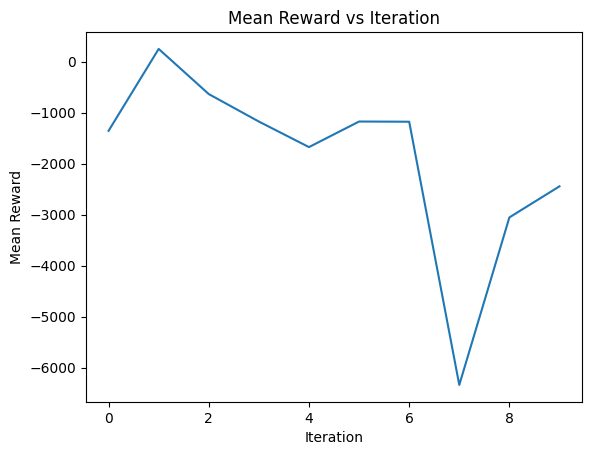

In [ ]:
import matplotlib.pyplot as plt

plt.plot(mean_rewards)
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
plt.title('Mean Reward vs Iteration')
plt.show()

In [ ]:
df = pd.DataFrame({
    'Iteración': iteraciones,
    'Recompensa Promedio': recompensa_promedio
})

print(df)

   Iteración  Recompensa Promedio
0          0          -898.391079
1          1         -1442.644619
2          2         -2068.909554
3          3          -941.190021
4          4         -2273.981505
5          5         -1436.962594
6          6         -1957.642897
7          7         -2121.576681
8          8         -2351.455759
9          9         -2475.172298


['timesteps', 'results', 'ep_lengths']


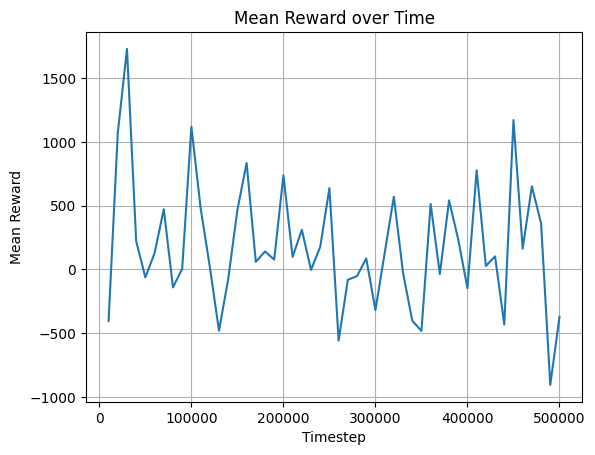

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar el archivo .npz
eval_data = np.load('./logs/eval/evaluations.npz')

# Listar las claves en el archivo .npz
print(eval_data.files)

# Supongamos que el archivo tiene las claves 'results' y 'timesteps'
# Acceder a los datos
results = eval_data['results']
timesteps = eval_data['timesteps']

# Calcular la recompensa promedio si es necesario (depende del formato de results)
mean_rewards = results.mean(axis=1)  # Promedio de recompensas por evaluación

# Graficar las recompensas promedio
plt.plot(timesteps, mean_rewards)
plt.xlabel('Timestep')
plt.ylabel('Mean Reward')
plt.title('Mean Reward over Time')
plt.grid()
plt.show()

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
import os
import pandas as pd

path_save = "/content/drive/MyDrive/Ant_custom/"

iteraciones = []
recompensa_promedio=[]

os.makedirs(path_save, exist_ok=True)


if os.path.exists("/content/drive/MyDrive/Ant_custom/SAC_Ant_2.zip"):
    model = SAC.load("/content/drive/MyDrive/Ant_custom/SAC_Ant_2.zip", env = env)
    print("Model loaded")
else:
    model = SAC('MlpPolicy', env,learning_rate=3e-4,policy_kwargs=policy_kwargs, verbose=1, batch_size=64)
    print("Model created")


model.learn(total_timesteps=500000, log_interval = 10,callback=eval_callback)
# Save the agent
model.save(path_save+"SAC_Ant_2")
mean_reward, std_reward = evaluar_modelo(model, 10, env)
print(f'mean reward: {mean_reward}, std reward: +/-{std_reward}')

del model


  20% ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98,859/500,000  [ 0:34:14 < 1:40:30 , 67 it/s ]

KeyboardInterrupt: 

['timesteps', 'results', 'ep_lengths']


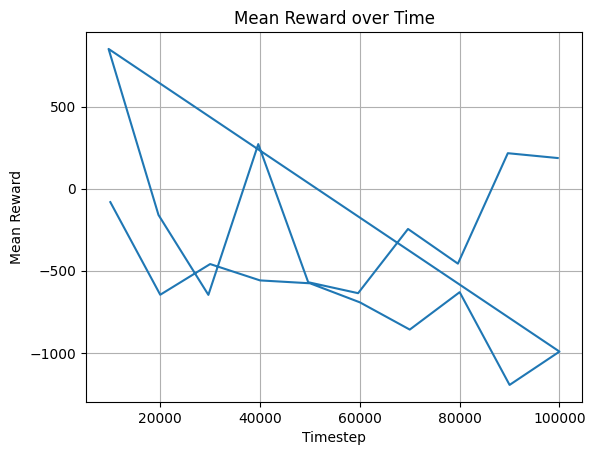

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar el archivo .npz
eval_data = np.load('./logs/eval/evaluations.npz')

# Listar las claves en el archivo .npz
print(eval_data.files)

# Supongamos que el archivo tiene las claves 'results' y 'timesteps'
# Acceder a los datos
results = eval_data['results']
timesteps = eval_data['timesteps']

# Calcular la recompensa promedio si es necesario (depende del formato de results)
mean_rewards = results.mean(axis=1)  # Promedio de recompensas por evaluación

# Graficar las recompensas promedio
plt.plot(timesteps, mean_rewards)
plt.xlabel('Timestep')
plt.ylabel('Mean Reward')
plt.title('Mean Reward over Time')
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Graficar el DataFrame
df.plot(x='Iteración', y='Recompensa Promedio', marker='o', title='Recompensa Promedio por Iteración')

# Añadir etiquetas a los ejes
plt.xlabel('Iteraciones')
plt.ylabel('Recompensa Promedio')

# Mostrar el gráfico
plt.show()

In [ ]:
model = SAC.load("/content/drive/MyDrive/Ant_custom/SAC_Ant.zip", env = env)
print("Model loaded")

done = False
rewards = []
obs = env.reset()
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    rewards.append(reward)
print(np.sum(rewards))


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Model loaded
17813.64762507759


In [ ]:
model = PPO('MlpPolicy', env,learning_rate=0.0025,policy_kwargs=policy_kwargs, verbose=1)
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=2)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


mean_reward:40004.00 +/- 0.00


In [ ]:
env = gym.make('AntCustomEnv-v0')


model = PPO.load("/content/logs/best_model/best_model.zip", env = env)
images = []
obs = env.reset()
img = env.render(mode="rgb_array")
#plt.imshow(img)


for i in range(2000):
    images.append(img.astype(np.uint8))
    action, _ = model.predict(obs)
    obs, _, _ ,_ = env.step(action)
    img = env.render(mode="rgb_array")
env.close()
print("Aqui")
imageio.mimsave("Ant_bullet_PPO_SIMPLE.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Aqui


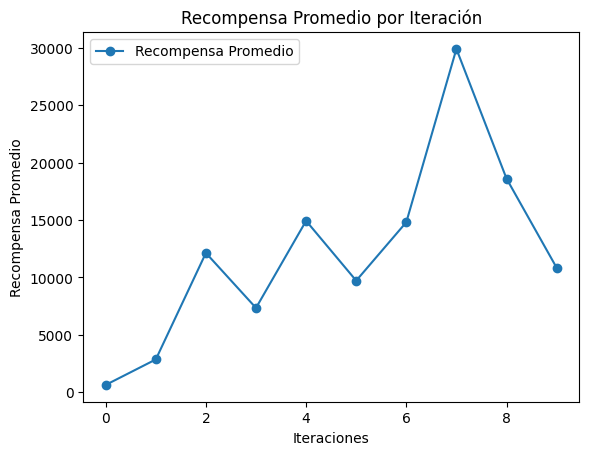

In [ ]:
import matplotlib.pyplot as plt
# Graficar el DataFrame
df.plot(x='Iteración', y='Recompensa Promedio', marker='o', title='Recompensa Promedio por Iteración')

# Añadir etiquetas a los ejes
plt.xlabel('Iteraciones')
plt.ylabel('Recompensa Promedio')

# Mostrar el gráfico
plt.show()

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
import os
path_save = "/content/drive/MyDrive/Ant_custom/"

iteraciones = []
recompensa_promedio=[]


os.makedirs(path_save, exist_ok=True)


if os.path.exists("/content/drive/MyDrive/Ant_custom/SAC_Ant_2.zip"):
    model = SAC.load("/content/drive/MyDrive/Ant_custom/SAC_Ant_2.zip", env = env)
    print("Model loaded")
else:
    model = SAC('MlpPolicy', env,learning_rate=0.0025,policy_kwargs=policy_kwargs, verbose=1)
    print("Model created")


for i in range(10):
    print("Training itteration ",i)
    model.learn(total_timesteps=20)
    # Save the agent
    model.save(path_save+"SAC_Ant_2")
    mean_reward, std_reward = evaluar_modelo(model, 10, env)
    print("mean_reward ", mean_reward)
    if mean_reward >= MAX_AVERAGE_SCORE:
        print("***Agent Trained with average reward ", mean_reward)
        break
    iteraciones.append(i)
    recompensa_promedio.append(mean_reward)
    print(f'mean reward: {mean_reward}, std reward: +/-{std_reward}')


del model

df = pd.DataFrame({
    'Iteración': iteraciones,
    'Recompensa Promedio': recompensa_promedio
})

print(df)


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Model loaded
Training itteration  0
mean_reward  378.17686724501925
mean reward: 378.17686724501925, std reward: +/-555.9957803267839
Training itteration  1
mean_reward  159.37415188333608
mean reward: 159.37415188333608, std reward: +/-217.17124513310887
Training itteration  2
mean_reward  165.84878585400523
mean reward: 165.84878585400523, std reward: +/-150.37113821880047
Training itteration  3
mean_reward  198.22377026323653
mean reward: 198.22377026323653, std reward: +/-164.0451719080087
Training itteration  4
mean_reward  197.381793109169
mean reward: 197.381793109169, std reward: +/-226.37293657105934
Training itteration  5
mean_reward  346.67471521230345
mean reward: 346.67471521230345, std reward: +/-291.11044955512324
Training itteration  6
mean_reward  272.57130067124166
mean reward: 272.57130067124166, std reward: +/-235.16592183326168
Training itteration  7
mean_reward  460.4641024374155
mean rew

KeyboardInterrupt: 